C:\Users\steph\AppData\Local\Temp\ipykernel_3100\2088070044.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
c:\Users\steph\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\steph\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\steph\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\steph\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\steph\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


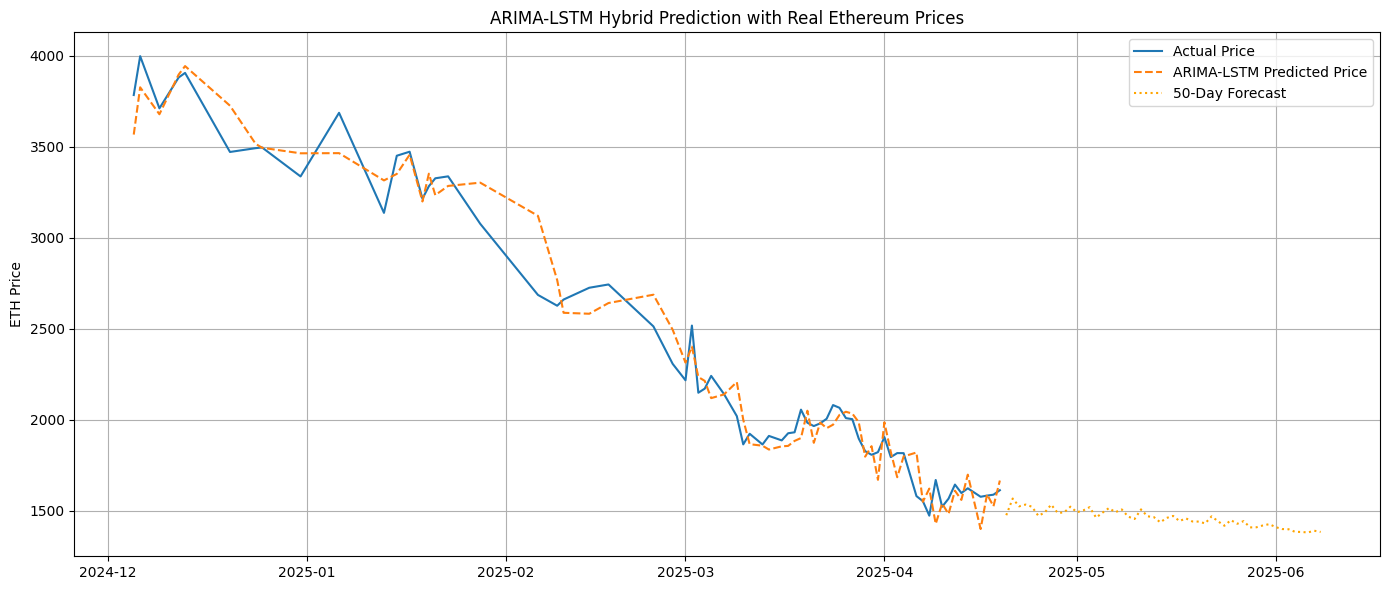

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
df = pd.read_csv("../dataset/eth_sentiment_scored.csv")
df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
df.sort_values('published_date', inplace=True)

# Use actual BTC prices from dataset
df['price_eth'] = df['price_eth'].astype(float)

# Clean sentiment mapping
df['sentiment_score'] = df['sentiment'].map({
    'positive': 1,
    'neutral': 0,
    'negative': -1
}).fillna(0)

# Aggregate by date
daily_df = df.groupby('published_date').agg({
    'sentiment_score': 'mean',
    'price_eth': 'mean'
}).reset_index()
daily_df.set_index('published_date', inplace=True)

# Fit ARIMA model
price_series = daily_df['price_eth']
arima_model = ARIMA(price_series, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=1, end=len(price_series)-1, typ='levels')
residuals = price_series[1:] - arima_pred

# Prepare features for LSTM
lstm_df = daily_df.iloc[1:].copy()
lstm_df['residual'] = residuals

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lstm_df[['sentiment_score', 'residual']])

# Prepare sequences
X, y = [], []
seq_len = 5
for i in range(seq_len, len(scaled_features)):
    X.append(scaled_features[i-seq_len:i, 0:2])
    y.append(scaled_features[i, 1])
X, y = np.array(X), np.array(y)

# Build and train LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=100, batch_size=8, verbose=0)

model.save("eth_lstm_model.h5")

# Predict residuals
predicted_residuals = model.predict(X)
temp = np.zeros((predicted_residuals.shape[0], 2))
temp[:, 1] = predicted_residuals[:, 0]
inv_residuals = scaler.inverse_transform(temp)[:, 1]

# Combine ARIMA + LSTM
final_arima = arima_pred.iloc[seq_len:].values
final_predicted_price = final_arima + inv_residuals

## saved ARIMA + LSTM df
predicted_dates = price_series.index[seq_len+1:]

# Create DataFrame
hist_pred = pd.DataFrame({
    "date": predicted_dates,
    "model_predicted_price": final_predicted_price
})
hist_pred.set_index("date", inplace=True)
hist_pred.to_csv("eth_hist_pred.csv", index=True)

# Forecast future
future_days = 50
last_sentiment = daily_df['sentiment_score'].iloc[-1]

np.random.seed(42)
future_sentiments = [last_sentiment]
for _ in range(future_days - 1):
    next_val = future_sentiments[-1] + np.random.normal(0, 0.1)
    future_sentiments.append(np.clip(next_val, -1, 1))
future_sentiments = np.array(future_sentiments)

future_arima = arima_result.forecast(steps=future_days)

future_X = []
last_scaled = scaled_features[-seq_len:].copy()
for sentiment in future_sentiments:
    new_input = last_scaled.copy()
    new_input[:-1] = new_input[1:]
    new_input[-1, 0] = sentiment
    new_input[-1, 1] = 0
    future_X.append(new_input)
    last_scaled = new_input

future_X = np.array(future_X)
future_residuals = model.predict(future_X)

temp_future = np.zeros((future_residuals.shape[0], 2))
temp_future[:, 1] = future_residuals[:, 0]
inv_future_residuals = scaler.inverse_transform(temp_future)[:, 1]
future_price_pred = future_arima + inv_future_residuals

# Dates for forecast
last_date = daily_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Save predictions to df
pred_df = pd.DataFrame({
    "date": future_dates,
    "eth_predicted_price": future_price_pred
})
pred_df.to_csv("eth_predicted_prices.csv", index=False)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(price_series.index[seq_len+1:], price_series.values[seq_len+1:], label='Actual Price')
plt.plot(price_series.index[seq_len+1:], final_predicted_price, label='ARIMA-LSTM Predicted Price', linestyle='--')
plt.plot(future_dates, future_price_pred, label='50-Day Forecast', linestyle=':', color='orange')
plt.title("ARIMA-LSTM Hybrid Prediction with Real Ethereum Prices")
plt.ylabel("ETH Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation of Training Model

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0293 - val_loss: 0.0235
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - val_loss: 0.0242
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0345 - val_loss: 0.0245
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - val_loss: 0.0249
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0297 - val_loss: 0.0254
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0319 - val_loss: 0.0262
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301 - val_loss: 0.0260
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0324 - val_loss: 0.0259
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 - val_loss: 0.0261
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - val_loss: 0.0271
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0250 - val_loss: 0.0268


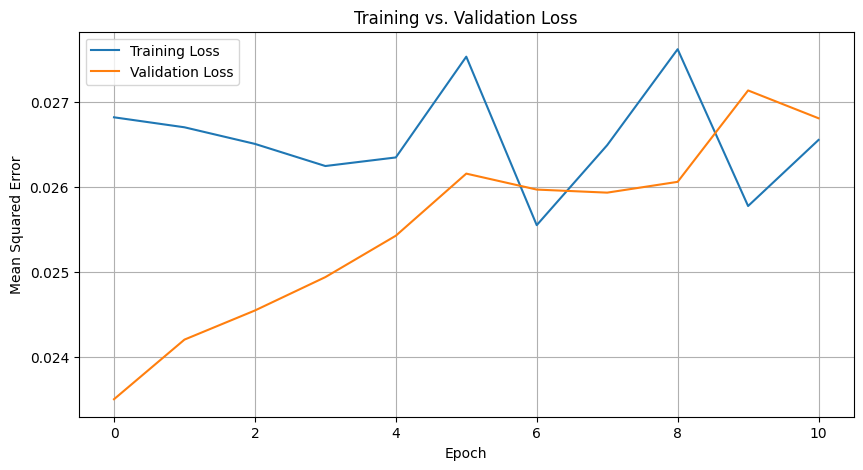

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Add EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation split
history = model.fit(
    X, y,
    epochs=100,
    batch_size=8,
    validation_split=0.2,  # 20% of data for validation
    callbacks=[early_stop],
    verbose=1
)
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
price_series.to_csv("eth_price_series.csv", index=True)

In [11]:
for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")


Epoch 1: Training Loss = 0.026822, Validation Loss = 0.023501
Epoch 2: Training Loss = 0.026704, Validation Loss = 0.024203
Epoch 3: Training Loss = 0.026509, Validation Loss = 0.024546
Epoch 4: Training Loss = 0.026248, Validation Loss = 0.024940
Epoch 5: Training Loss = 0.026349, Validation Loss = 0.025427
Epoch 6: Training Loss = 0.027536, Validation Loss = 0.026159
Epoch 7: Training Loss = 0.025552, Validation Loss = 0.025971
Epoch 8: Training Loss = 0.026494, Validation Loss = 0.025935
Epoch 9: Training Loss = 0.027624, Validation Loss = 0.026062
Epoch 10: Training Loss = 0.025777, Validation Loss = 0.027138
Epoch 11: Training Loss = 0.026555, Validation Loss = 0.026811


In [12]:
print("Price data sample:")
print(daily_df['price_eth'].head(10))

print("\nARIMA predicted sample:")
print(arima_pred.head(10))

print("\nFinal predicted price sample:")
print(final_predicted_price[:10])

print("\nFuture predicted price sample:")
print(future_price_pred[:10]) # future_price_pred --> eto ung guide mo for getting the predicted price per day.


Price data sample:
published_date
2024-11-23    3393.91
2024-11-24    3361.20
2024-11-25    3414.49
2024-11-26    3324.73
2024-11-28    3578.79
2024-11-29    3592.21
2024-12-05    3785.20
2024-12-06    3998.87
2024-12-09    3712.00
2024-12-12    3881.61
Name: price_eth, dtype: float64

ARIMA predicted sample:
published_date
2024-11-24    3369.667865
2024-11-25    3368.009723
2024-11-26    3399.629017
2024-11-28    3349.391377
2024-11-29    3507.044433
2024-12-05    3580.264782
2024-12-06    3727.275256
2024-12-09    3929.747810
2024-12-12    3788.402738
2024-12-13    3840.404651
Name: predicted_mean, dtype: float64

Final predicted price sample:
[3567.85501537 3827.63062978 3679.5400319  3897.65224532 3944.29153767
 3726.57911464 3516.85433335 3495.35671214 3464.92002521 3465.7715613 ]

Future predicted price sample:
75    1475.905965
76    1567.450406
77    1524.583909
78    1534.225670
79    1522.412600
80    1472.234540
81    1490.934217
82    1534.017443
83    1489.012901
84    149

# Sentiment-Value (Records)

In [13]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt



# Load dataset
df = pd.read_csv("dataset/ethereum_sentiment.csv")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute compound sentiment score
df['compound'] = df['post'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Plotting the sentiment score distribution
plt.figure(figsize=(10, 6))
plt.hist(df['compound'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
# Optionally, save the updated DataFrame


df.to_csv("dataset/ethereum_sentiment_scored.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/ethereum_sentiment.csv'

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# True and predicted values for evaluation (excluding forecast)
true_values = price_series.values[seq_len+1:]
predicted_values = final_predicted_price

# Evaluation metrics
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
r2 = r2_score(true_values, predicted_values)
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
pseudo_accuracy = 100 - mape



# Print the scores
print("Model Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"Pseudo Accuracy: {pseudo_accuracy:.2f}%")


Model Evaluation Metrics:
MAE (Mean Absolute Error): 108.794412
RMSE (Root Mean Squared Error): 147.016221
R² Score: 0.961060
MAPE (Mean Absolute Percentage Error): 4.43%
Pseudo Accuracy: 95.57%


# Explanation

Evaluation Metrics:
Mean Absolute Error (MAE): 108.79
→ On average, the model's predictions are off by about $109, which is relatively small considering ETH’s price often fluctuates in the 1,500–4,000 range.

Root Mean Squared Error (RMSE): 147.02
→ This reinforces that large deviations are rare and the model maintains predictive stability.

R² Score: 0.9611
→ The model explains 96.11% of the variance in actual ETH prices. This is exceptionally high and indicates strong alignment with real price trends.

Mean Absolute Percentage Error (MAPE): 4.43%
→ On average, the predicted prices deviate by only 4.43%, making this model highly reliable for forecasting purposes.

Pseudo Accuracy (100 - MAPE): 95.57%
→ Roughly speaking, the model achieves around 95.6% prediction accuracy in percentage terms.

- The Ethereum model exhibits excellent performance, with both low error rates and high explanatory power.

- The very high R² and low MAPE suggest the model is neither underfitting nor overfitting, and it generalizes well to new data.

- Given Ethereum’s volatility, achieving sub-5% error is impressive and makes this model well-suited for trend analysis, risk management, or investment strategy simulations.

